In [1]:
import sys
import os
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from circle_trajectory import * # File for Calculation of Input Data for Circles and Ellipses and Target Calculation.
import matplotlib as mpl
from celluloid import Camera # 
from gc_linreg import *
from plotter import * 

'''Decide how you want to run the Simulation'''

In [2]:
''' Run make_all_the_plots in console for several plots. Explanation at def make_all_the_plots '''



'''Make Gif Parameters and Toogle'''

make_gif=False

'''If true at the moment three files will be saved to the same folder as the cerebellum file
1. Log file of what was printed in the console
2. GC Fire Rates while Testing
3. Test predictions.
This is generally not needed.
'''
save_data = False

''' If true - create and save gc_matrix.npz to folder. gc_matrix contains matrix of
gc activity linreg fitted to dx,dy '''
save_gc_matrix = False

''' If false training_input and training_targets will be taken from datafile calculon.npz
if true, data will be created before first epoch of training.'''
make_new_training_circle_data = False 

'''Definition of the parameters'''

In [3]:
number_in = 4
number_gc = 1000
number_goc = 100
number_pn = 2
number_pc = number_pn * 10
number_io = number_pn
sparsity_factor = 1
number_gc_pc = int(number_gc/number_pc*number_pn/sparsity_factor)

tau_gc_goc = 1
tau_goc_gc = 50

convergence_gc_goc = 10
convergence_goc_gc = 4

mean_gc_goc = 50 / tau_gc_goc
var_gc_goc = 4 * mean_gc_goc
mean_goc_gc = 0.05 / tau_goc_gc
var_goc_gc = 0 * mean_goc_gc

d_stim = 20
d_delay = 50
d_response = 5

number_epochs = 2

number_training_examples = 1080 # Number of trail steps or rather steps taken in the circle. 
number_test_examples = 1080 # Number of trail steps or rather steps taken in the circle. 

recording_interval = 2

arm_length = [0.5, 0.5]
# number_training_trajectories = 500 
pn_baselines = np.random.normal(1.2, 0.1, number_pn)


''' More definitions and loading of training_data_set'''
# In[3]:
    
training_input = np.zeros((number_training_examples, number_in))    
training_targets = np.zeros((number_training_examples, number_pn))    
test_input = np.zeros((number_test_examples, number_in))
test_targets = np.zeros((number_test_examples, number_pn))

In [4]:
from ANNarchy import *
# setup(paradigm="cuda") # to compute on GPU
clear()

ANNarchy 4.6 (4.6.8.1) on linux (posix). 


''' Neurons and Synapses Definitions:'''

In [5]:
neuron = Neuron(
    parameters="""
        g = 1.0 : population
        tau = 1.    : population    # Time constant
        f = 1.0    # Push-pull factor
     """,
    equations="""
        # Integrate firing rate over time
        r = rate + exp(-1/tau) * r
        # Firing rate
        rate = g * sum(in) + sum(inh) + sum(exc) : min=0.0
    """
)


purkinje_cell = Neuron(
    parameters="""
        error_change = 0.0
        tau = 1. : population    # Time constant
    """,
    equations="""
        # Integrate firing rate over time
        r = rate + exp(-1/tau) * r
        perturbation = sum(perturb)
        # Firing rate
        rate = sum(exc) + perturbation : min=0.0
    """
)

inferior_olive_neuron = Neuron(
    parameters="""
        tau = 1. : population    # Time constant
        frequency=50.0 : population    # Frequency of perturbation
        amplitude=0.1 : population    # Amplitude of perturbation
        start_perturb=0.0  # Control when to apply perturbations
    """,
    equations="""
        # Integrate firing rate over time
        r = rate + exp(-1/tau) * r
        # Random perturbations
        rate = if Uniform(0.0, 1.0) < frequency/350 : 
                            start_perturb * amplitude
                        else : 
                            0.0
    """
)

mossy_fibre = Synapse(
    parameters="""
        baseline = 1.0
    """,
    equations="""
        potential = baseline + baseline * post.f * pre.r : min = 0.0
    """,
    psp="""
        potential 
    """
)

gc_pc_synapse = Synapse(
    parameters="""
        learning_phase = 0.0 : projection   # Update weights at end of trial
        eta = 2e-2  : projection         # Learning rate
        max_weight_change = 5e-1: projection     # Clip weight changes
        start_trace = 0.0 : projection      # Control when to compute eligibility trace
    """,
    equations="""
        # Eligibility trace
        trace += if learning_phase < 0.5 : 
                        start_trace * (pre.r-mean(pre.r)) * post.perturbation
                    else : 
                        0.0

        # Weight update
        delta_w = if learning_phase > 0.5 : 
                    eta * trace * post.error_change         
                else : 
                    0.0      : min = -max_weight_change, max = max_weight_change
        w -= delta_w : min = 0.0   
    """
)

gc_me_synapse = Synapse(
    parameters="""
        learning_phase = 0.0 : projection   # Update weights at end of trial
        eta = 0.0002  : projection         # Learning rate
        max_weight_change = 5e-1: projection     # Clip weight changes
        start_trace = 0.0 : projection      # Control when to compute eligibility trace
    """,
    equations="""
        # Eligibility trace
        trace += if learning_phase < 0.5 : 
                    start_trace * pre.r
                else : 
                    0.0

        # Weight update
        delta_w = if learning_phase > 0.5 : 
                eta * trace * post.error_change         
            else : 
                0.0      : min = -max_weight_change, max = max_weight_change
        w += delta_w    
  """
)

'''Populations:'''

In [6]:
pop_input = Population(number_in, Neuron("r=0.0"), name="pop_input")

pop_granule_cells = Population(number_gc, neuron, name="pop_granule_cells")

pop_golgi_cells = Population(number_goc, neuron, name="pop_golgi_cells")

pop_purkinje_cells = Population(number_pc, purkinje_cell, name="pop_purkinje_cells")

pop_inferior_olive_neurons = Population(number_io, inferior_olive_neuron, name="pop_inferior_olive_neurons")

pop_mean_error_neuron = Population(1, purkinje_cell, name="pop_mean_error_neuron")

pop_projection_neuron = Population(number_pn, neuron, name="pop_projection_neuron")

'''Projections:'''

In [7]:
inp_gc = Projection(pop_input, pop_granule_cells, synapse=mossy_fibre, target="in", name="inp_gc")
inp_gc.connect_fixed_number_pre(1, weights=0.1)

inp_goc = Projection(pop_input, pop_golgi_cells, synapse=mossy_fibre, target="in", name="inp_goc")
inp_goc.connect_fixed_number_pre(1, weights=0.1)

gc_goc = Projection(pop_granule_cells, pop_golgi_cells, target="exc", name="gc_goc")
gc_goc.connect_fixed_number_pre(convergence_gc_goc, weights=Normal(mean_gc_goc, var_gc_goc),
                                force_multiple_weights=True)

goc_gc = Projection(pop_golgi_cells, pop_granule_cells, target="inh", name="goc_gc")
goc_gc.connect_fixed_number_pre(convergence_goc_gc, weights=Normal(mean_goc_gc, var_goc_gc),
                                force_multiple_weights=True)

inp_pn = Projection(pop_input, pop_projection_neuron, synapse=mossy_fibre, target="in", name="inp_pn")
inp_pn.connect_from_matrix(np.array([[0.1, None,None,None],[None,0.1,None,None]]))
# inp_pn.connect_from_matrix(np.array([[0, None,None,None],[None,0,None,None]]))

gc_pc_connect = np.empty((number_pc, number_gc), object)
for p in range(number_pc):
    index_factor = p % int(number_pc/number_pn)
    gc_connect = np.empty(number_gc_pc * sparsity_factor, object)
    gc_connect[: number_gc_pc] = np.random.normal(0.1, 0.05, number_gc_pc)
    np.random.shuffle(gc_connect)
    gc_pc_connect[p, index_factor * number_gc_pc * sparsity_factor: (index_factor+1) * number_gc_pc * sparsity_factor] = gc_connect
gc_pc = Projection(pop_granule_cells, pop_purkinje_cells, target="exc", synapse=gc_pc_synapse, name="gc_pc")
gc_pc.connect_from_matrix(gc_pc_connect)


io_pc_connect = np.empty((number_pc, number_io), object)
io_pc_connect_counter_a=0
io_pc_connect_counter_b=10
for i in range(0,number_io):
    io_pc_connect[io_pc_connect_counter_a:io_pc_connect_counter_b,i]=1.0
    io_pc_connect_counter_a = (io_pc_connect_counter_a+10)
    io_pc_connect_counter_b = (io_pc_connect_counter_b+10)
io_pc = Projection(pop_inferior_olive_neurons, pop_purkinje_cells, target="perturb", name="io_pc")
io_pc.connect_from_matrix(io_pc_connect)

# pc_pn_connect = np.empty((number_pn, number_pc), object)
# pc_pn_connect_counter_a=0
# pc_pn_connect_counter_b=10
# for i in range(0,number_pn):
#     pc_pn_connect[i,pc_pn_connect_counter_a:pc_pn_connect_counter_b]=-0.01
#     pc_pn_connect_counter_a = (pc_pn_connect_counter_a+10)
#     pc_pn_connect_counter_b = (pc_pn_connect_counter_b+10)
# pc_pn = Projection(pop_purkinje_cells,pop_projection_neuron, target="inh", name="pc_pn")
# pc_pn.connect_from_matrix(pc_pn_connect)

gc_matrix = np.load('gc_matrix.npz')
gc_matrix = gc_matrix['arr_0']
gc_matrix=gc_matrix*75
gc_pn = Projection(pop_granule_cells, pop_projection_neuron, target="inh", name="gc_pn")
gc_pn.connect_from_matrix(gc_matrix)

gc_me = Projection(pop_granule_cells, pop_mean_error_neuron, target="exc", synapse=gc_me_synapse, name="gc_me")
gc_me.connect_fixed_probability(0.5, weights=Uniform(0.0, 0.1), force_multiple_weights=True)


'''Monitors:'''

In [8]:
monitor_pn = Monitor(pop_projection_neuron, ['rate'])
monitor_me = Monitor(pop_mean_error_neuron, ['rate'])
monitor_gc = Monitor(pop_granule_cells, ['rate'])        

In [9]:
compile()

'''Set synaptic values per dendrite (inefficient?)'''

In [10]:
for dendrite in inp_gc.dendrites:
    dendrite.baseline = np.random.normal(1.2, 0.1)

for dendrite in inp_goc.dendrites:
    dendrite.baseline = np.random.normal(1.2, 0.1)

for dendrite in gc_goc.dendrites:
    dendrite.w = [0.0 if w < 0.0 else (w * 2 / convergence_gc_goc) for w in dendrite.w]

for dendrite in goc_gc.dendrites:
    dendrite.w = [0.0 if w < 0.0 else (w * 2 / convergence_goc_gc) for w in dendrite.w]
    dendrite.w = [-1. * w for w in dendrite.w]

for dendrite in gc_pc.dendrites:
    dendrite.w = [0.0 if w < 0.0 else w for w in dendrite.w]

for i in range(number_pn):
    dendrite = inp_pn.dendrite(i)
    dendrite.baseline = pn_baselines[i]
    print(dendrite.baseline)

pop_golgi_cells.tau = tau_goc_gc
pop_granule_cells.tau = tau_gc_goc
pop_golgi_cells.f = np.random.choice([-1.0, 1.0], number_goc)
pop_granule_cells.f = np.random.choice([-1.0, 1.0], number_gc)


[1.2467630415439601]
[1.3497626347920817]


'''Function to reset the network:'''

In [11]:
def reset_network():
    pop_granule_cells.rate = np.random.uniform(0.0, 0.1, number_gc)
    pop_granule_cells.r = np.random.uniform(0.0, 0.1, number_gc)
    pop_golgi_cells.rate = np.random.uniform(0.0, 0.1, number_goc)
    pop_golgi_cells.r = np.random.uniform(0.0, 0.1, number_goc)
    pop_input.r = .0
    pop_inferior_olive_neurons.start_perturb = .0
    gc_pc.start_trace = .0
    gc_me.start_trace =.0
    gc_pc.trace = .0
    gc_me.trace = .0


''' Definition of a learning trial:'''

In [12]:
def trial(inp, target, epoch):


    # Reset the network
    reset_network()


    # Set input
    pop_input.r = inp
    
    # Simulate for d_stim = 20 ms
    simulate(d_stim)
    
    # Delay period od d_delay = 50 ms
    pop_input.r = 0.0
    simulate(d_delay - 1)

    # Start computing eligibility trace and do one step (1 ms)
    gc_pc.start_trace = 1.0
    gc_me.start_trace = 1.0
    step()

    # Start applying perturbations
    pop_inferior_olive_neurons.start_perturb = 1.0

    # Simulate for d_response = 5 ms
    simulate(d_response)
            
    # Sample PN response
    rates_pn = monitor_pn.get('rate')
    response = rates_pn[-d_response:, :]
    response = np.mean(response, axis=0)
    
    # Map PN response to target range
    response = (response - (pn_baselines / 4)) / (pn_baselines / 2)
    response = response * 2 * np.sum(arm_length) - np.sum(arm_length)
    
    # Sample error estimate
    rates_me = monitor_me.get('rate')
    error_estimate = rates_me[-d_response:, :]
    error_estimate = np.mean(error_estimate)
    

    # Tell IO to start applying perturbation
    pop_inferior_olive_neurons.start_perturb = 0.0

    # Compute error
    error = (np.linalg.norm(target - response))**2

    # Update weights
    error_change = math.copysign(1.0, error - error_estimate)
    gc_pc.learning_phase = 1.0
    gc_me.learning_phase = 1.0
    pop_purkinje_cells.error_change = error_change
    pop_mean_error_neuron.error_change = error_change

    if epoch == 0:
        rates_gc = monitor_gc.get('rate')    
    # Run for one millisecond
    step()   
        
    # Learning finished
    gc_pc.learning_phase = 0.0
    gc_me.learning_phase = 0.0

    # Clear recordings of last step
    _ = monitor_pn.get()
    _ = monitor_gc.get()

    if epoch == 0 :
        return error, response, target, rates_gc
    else:
        return error, response, target


'''Main training loop:'''
  

'''Definition of Arrays needed for Plotting, Circle generation and GC Monitoring
    If no circle generation for training is active, data will be loaded (at the top of the srcript) from a pre generated dataset. claculon.npz  
    
    Generation of Circle. Calculations are done in seperate file. 
    circle data in order: 
    x
    y
    delta_theta_elbow
    delta_theta_shoulder
    x_next --> (target)
    y_next --> (target)'''


In [13]:
training_mses = np.zeros((number_epochs,1))
training_errors = np.zeros((number_epochs,number_training_examples,1))
training_predictions = np.zeros((number_epochs,number_training_examples,2))
training_targetslist = np.zeros((number_epochs,number_training_examples,2))
training_gc_response_list = np.zeros((number_training_examples, number_gc))


if make_new_training_circle_data == True:
    circledata=[]
    circletargets=np.zeros((number_test_examples,6))
    circledata=circle()
    circletargets=circle_trajectory(0.5,number_test_examples,(circledata[0],circledata[1]),circledata[2],0,circledata[3],None,False)
    training_input[:,0:4] = circletargets[:,0:4] 
    training_targets[:,0:2] = circletargets[:,4:6]
else: 
    data = np.load('calculon.npz')
    training_set = data['arr_0'] #training_set.shape = 1080,6 --> colums are: x_prev, y_prev, delta theta_elbow, delta theta_shoulder, x_next, y_next
    training_input[:, 0:4] = training_set[:,0:4] # input: x_prev, y_prev, delta theta_0, delta theta_1
    training_targets[:,0:2] = training_set[:, 4:6] # target:  x_next, y_next



# epochcutoff_list = list(range(10))
# epoch = 0
# epochcutoff = 5
# while epochcutoff >= 0.009:    
    
for epoch in range(number_epochs):

        
    if epoch == 1:
        gc_linreger, gc_matrix = gc_linreg(training_gc_response_list,training_targets-training_input[:,0:2])
        gc_matrix = np.transpose(gc_matrix)


    for index in range(number_training_examples):
        
        if epoch == 0:
            errors, prediction, targettheta, training_gc_rates  = trial(training_input[index, :], training_targets[index, :], epoch)
                    
            training_errors[epoch,index] = errors
            training_predictions[epoch,index] = prediction.reshape(1,2)
            training_targetslist[epoch,index] = training_targets[index, :]
            training_gc_response_list[index] = training_gc_rates[-1,:]

        else:
                
            errors, prediction, targettheta = trial(training_input[index, :], training_targets[index, :], epoch)
            training_errors[epoch,index] = errors
            training_predictions[epoch,index] = prediction.reshape(1,2)
            training_targetslist[epoch,index] = training_targets[index, :]
                 
    
        # Dynamic reduction of eta    
        training_mses[epoch] = np.mean(errors)
        if np.round(np.mean(errors),4) < 0.15:
            gc_pc.eta = 2e-3
            if np.round(np.mean(errors),4) < 0.05:
                gc_pc.eta = 2e-4
                if np.round(np.mean(errors),4) < 0.01:
                    gc_pc.eta= 2e-5
                    
    print("Epoch: ",epoch+1, "      mse Training: ", np.round(np.mean(errors),4), "        Predictions: ", np.round(prediction,4))
    
        
    if save_data == True:
    #Print into file timespamped_logfile.txt 
        print("Epoch: ",epoch+1, "      mse Training: ", np.round(np.mean(errors),4), "        Predictions: ", np.round(prediction,4), file=open(time.strftime("%Y%m%d%H%M%S")+"_logfile",'w+'))
        
    
    # epoch+=1
    # del epochcutoff_list[0]
    # epochcutoff_list.append(training_mses[epoch-1])
    # epochcutoff = np.mean(epochcutoff_list)


Epoch:  1       mse Training:  85.6004         Predictions:  [9.0806 2.1814]
Epoch:  2       mse Training:  90.9083         Predictions:  [9.3623 2.2121]


''' Definition of Test Trial:'''

In [14]:
def test(inp, target):

    # Reset the network
    reset_network()

    # Set input
    pop_input.r = inp
    
    # Simulate for d_stim = 20 ms
    simulate(d_stim)
    
    # Delay period od d_delay = 50 ms
    pop_input.r = 0.0
    simulate(d_delay - 1)

    # Start computing eligibility trace and do one step (1 ms)
    gc_pc.start_trace = 1.0
    gc_me.start_trace = 1.0
    step()

    # Start applying perturbations
    pop_inferior_olive_neurons.start_perturb = 1.0

    # Simulate for d_response = 5 ms
    simulate(d_response)
            
    # Sample PN response250
    rates_pn = monitor_pn.get('rate')
    response = rates_pn[-d_response:, :]
    response = np.mean(response, axis=0)
    
    # Map PN response to target range
    response = (response - (pn_baselines / 4)) / (pn_baselines / 2)
    response = response * 2 * np.sum(arm_length) - np.sum(arm_length)

    # Sample error estimate
    rates_me = monitor_me.get('rate')
    error_estimate = rates_me[-d_response:, :]
    error_estimate = np.mean(error_estimate)

    # Tell IO to stop applying perturbation
    pop_inferior_olive_neurons.start_perturb = 0.0
    
    rates_gc = monitor_gc.get('rate')        
    step()
    # Compute error
    error = (np.linalg.norm(target - response))**2
    # Clear recordings of last step
    _ = monitor_pn.get()

    return error, response, rates_gc


'''Test Loop'''

In [15]:
'''Generation of Test Circle. Calculations are done in seperate file. 
   circle data in order: 
    x
    y
    delta_theta_elbow
    delta_theta_shoulder
    x_next --> (target)
    y_next --> (target)'''

circledata=[]
circletargets=np.zeros((number_test_examples,6))

circledata=circle()
circletargets=circle_trajectory(0.5,number_test_examples,(circledata[0],circledata[1]),circledata[2],0,circledata[3],None,False)
test_input[:, 0:4] = circletargets[:,0:4] 
test_targets[:,0:2] = circletargets[:, 4:6]    



# for i in range(1):

    # circledata=[]
    # circletargets=np.zeros((number_test_examples,6))
    
    # circledata=circle()
    # circletargets=circle_trajectory(0.5,number_test_examples,(circledata[0],circledata[1]),circledata[2],0,circledata[3],None,False)
    # test_input[:, 0:4] = circletargets[:,0:4] 
    # test_targets[:,0:2] = circletargets[:, 4:6]
    


'''Test Loop:'''
# In[ ]:
test_mses = []
test_errors = []
test_predictions = np.zeros((number_test_examples,2))
test_targetslist = np.zeros((number_test_examples,2))
test_gc_response_list = np.zeros((number_test_examples,number_gc))



for index in range(number_test_examples):
    test_error, test_prediction, test_gc_rates = test(test_input[index, :], test_targets[index, :])
    
    test_errors.append(test_error)
    test_predictions[index] = test_prediction
    test_targetslist[index] = test_targets[index, :]
    test_gc_response_list[index] = test_gc_rates[-1,:]
    
test_mses.append(np.mean(test_errors))


'''Save Data'''

In [16]:
if save_data == True:
# Test GC Rates are monitored and saved in timestamped file. 
# This was done to correlate gc_rates. Kept because it might still be needed.
    np.savez(time.strftime("%Y%m%d%H%M%S") + "_gc_rates.npz", test_gc_response_list.reshape(1080,1000))
    np.savez(time.strftime("%Y%m%d%H%M%S") + '_test_predictions', test_predictions.reshape(1080,2))

if save_gc_matrix == True:    
    gc_linreger, gc_matrix = gc_linreg(training_gc_response_list,training_targets-training_input[:,0:2])
    np.savez('gc_matrix.npz', np.transpose(gc_matrix))


'''Function for all the Plots.'''

In [17]:
def make_all_the_plots():
    
   
    #Training Plots 
    gc_activtiy_linreg_fit_target ("Training GC Rates fitted to Targets", training_gc_response_list, training_targets) # plots gc_activtiy lin reg fitted to targets
    # Figure with Euclidian Distance of TEST Predictions vs Targets, + Target in the same Figure, X,Y-Axis are the Coordinates
    mse_plot("Complete Training Predictions and Target over Time", training_targetslist.reshape(number_training_examples*number_epochs,2),training_predictions.reshape(number_training_examples*number_epochs,2),training_errors.reshape(number_training_examples*number_epochs,1)) 
    
    #Test Plots
    gc_activtiy_linreg_fit_target ("Test GC Rates ftted to Targets", test_gc_response_list, test_targets) # plots gc_activtiy lin reg fitted to targets
    # Figure with Euclidian Distance of TEST Predictions vs Targets, + Target in the same Figure, X,Y-Axis are the Coordinates
    mse_plot("Complete Test Predictions and Target", test_targetslist, test_predictions, test_errors) # MSE over Trails and Targets
    
    # Sum of Weighted GC rates vs Targets over all Trails and over Trail 1080
    plot_prediction_over_trials(training_gc_response_list, gc_matrix, training_targets)
    plot_prediction_within_trial(training_gc_rates, gc_matrix, training_targets, index)
    
    
    plt.scatter(training_predictions[1,:,0],training_predictions[1,:,1], s=0.5)
    plt.scatter(test_predictions[:,0],test_predictions[:,1], s=0.5)
    plt.title('Predictions --- Blue/Training - Orange/Test')


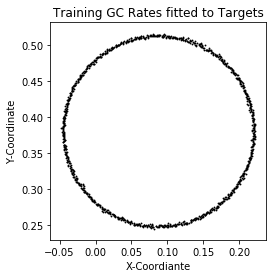

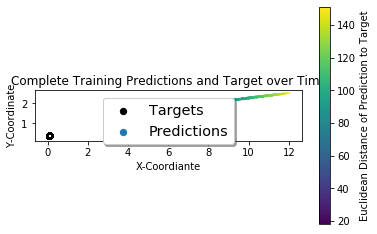

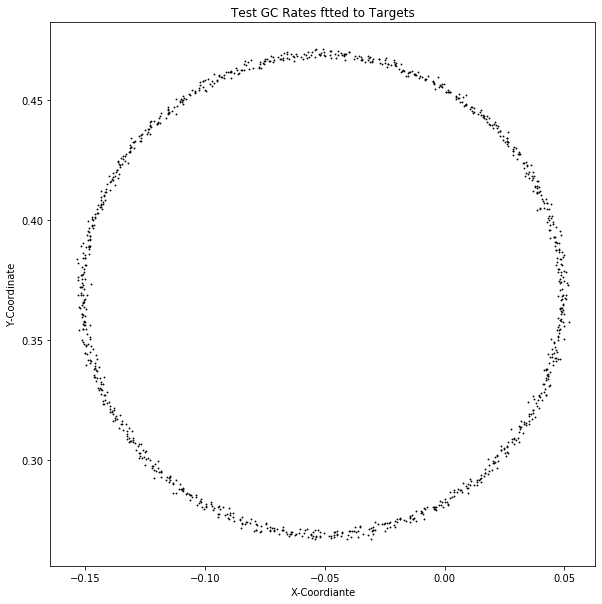

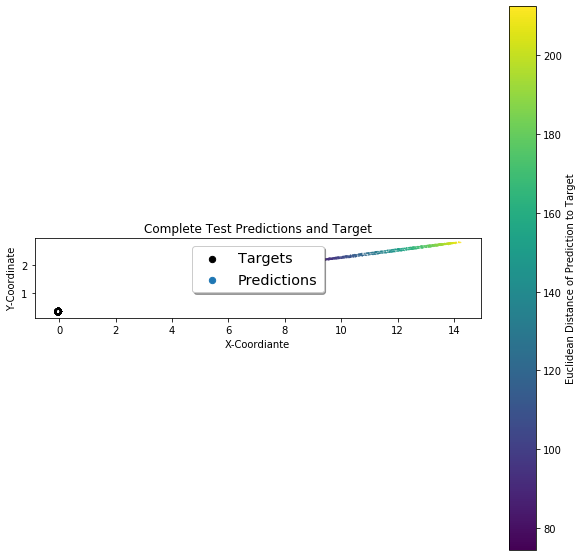

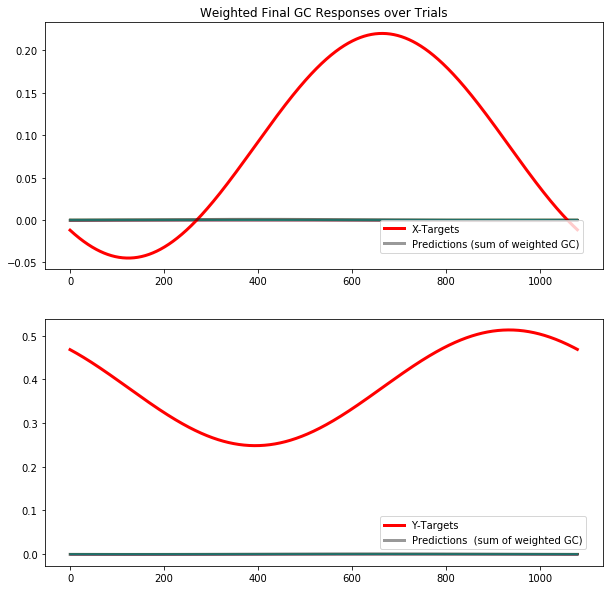

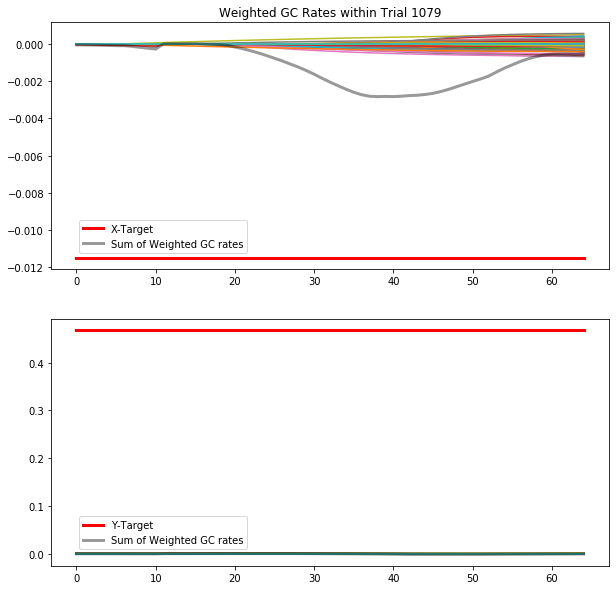

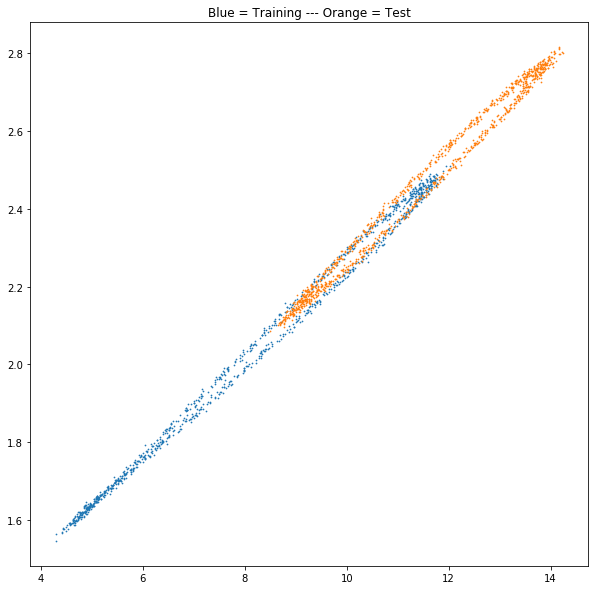

In [18]:
make_all_the_plots()